# MC simulation for ToF of a particle in 1D

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def simulate_telegraph_continuous(tau: float, t_max: float, v0: float = 1.0, x0: int | None = None):
    """
    Retourne
    --------
    times_full : np.ndarray
        Instants incluant t=0, les dates de changement et t_max.
    positions  : np.ndarray
        Position de la particule à ces instants (trajectoire continue).
    xs_full    : np.ndarray
        Signal directionnel (utile si on veut superposer).
    """
    if x0 is None:
        x = random.choice([-1, 1])
    elif x0 in (-1, 1):
        x = x0
    else:
        raise ValueError("x0 doit être ±1")

    t = 0.0
    times = [t]
    xs = [x]

    # Génération des dates de changement
    while t < t_max:
        dt = random.expovariate(1.0 / tau)
        t += dt
        if t > t_max:
            break
        x = random.choice([-1, 1])
        times.append(t)
        xs.append(x)

    # Construction des tableaux complets
    times_full = np.append(times, t_max)
    xs_full = np.append(xs, xs[-1])

    # Intégration de la vitesse
    dt = np.diff(times_full)
    displacements = v0 * xs_full[:-1] * dt
    positions = np.concatenate(([0.0], np.cumsum(displacements)))

    return times_full, positions, xs_full


## Démo

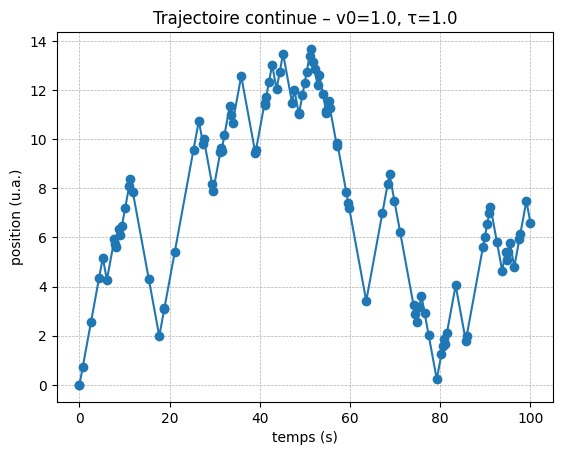

In [3]:
tau, t_max, v0 = 1.0, 100.0, 1.0
times_full, positions, xs_full = simulate_telegraph_continuous(tau, t_max, v0, x0=1)

plt.plot(times_full, positions, marker='o')
plt.xlabel("temps (s)")
plt.ylabel("position (u.a.)")
plt.title(f"Trajectoire continue – v0={v0}, τ={tau}")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [4]:
def hitting_probability(L: float, tau: float, v0: float = 1.0, n_sims: int = 20000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    success = 0
    for _ in range(n_sims):
        pos = 0.0
        direction = 1
        while True:
            dt = rng.exponential(scale=tau)
            pos_new = pos + direction * v0 * dt
            if direction == 1:
                if pos_new >= L:
                    success += 1
                    break
            else:
                if pos_new < 0:
                    break
            pos = pos_new
            direction = rng.choice([-1, 1])
    p = success / n_sims
    se = np.sqrt(p * (1 - p) / n_sims)
    return p, se

In [5]:
# Parameters
L = 5.0
v0 = 1.0
n_sims = 20000
tau_values = np.linspace(0.1, 5.0, 25)

probs = []
errors = []
rng = np.random.default_rng(42)
for tau in tau_values:
    p_hat, se = hitting_probability(L, tau, v0, n_sims, rng)
    probs.append(p_hat)
    errors.append(se)

probs = np.array(probs)
errors = np.array(errors)

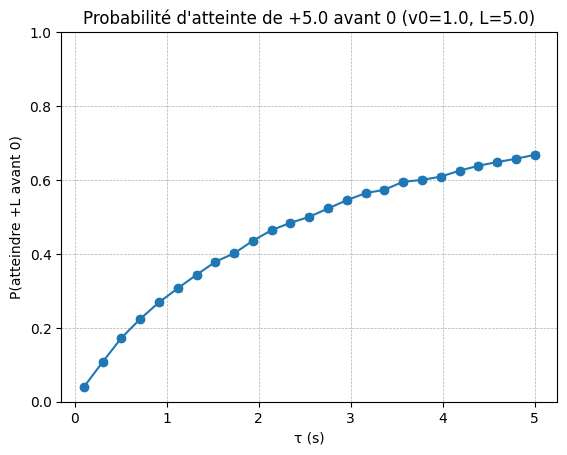

In [6]:
# Plot
plt.errorbar(tau_values, probs, yerr=1.96*errors, fmt='-o', capsize=3)
plt.xlabel("τ (s)")
plt.ylabel("P(atteindre +L avant 0)")
plt.title(f"Probabilité d'atteinte de +{L} avant 0 (v0={v0}, L={L})")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 1)
plt.show()

In [100]:
def mean_hitting_time(L: float, tau: float, v0: float = 1.0, n_sims: int = 20000, rng=None):
    """
    Retourne <T | succès> et son erreur-type.
    """
    if rng is None:
        rng = np.random.default_rng()
    times = []
    for _ in range(n_sims):
        pos = 0.0
        direction = 1
        t = 0.0
        while True:
            dt = rng.exponential(scale=tau)
            t += dt
            pos_new = pos + direction * v0 * dt
            if direction == 1 and pos_new >= L:
                times.append(t)
                break
            if direction == -1 and pos_new < 0:
                break
            pos = pos_new
            direction = rng.choice([-1, 1])
    if not times:
        return np.nan, np.nan
    times = np.array(times)
    return times.mean(), times.std(ddof=1) / np.sqrt(len(times))

In [121]:
# Paramètres
L = 5.0
v0 = 1.0
n_sims = 2000
tau_values = np.logspace(0.1,1.0,10)
mfp = 0.15

mean_times, errors = [], []
rng = np.random.default_rng(124)
for tau in tau_values:
    v0 = mfp / tau
    m, se = mean_hitting_time(L, tau, v0=(mfp/tau), n_sims=n_sims, rng=rng)
    mean_times.append(m)
    errors.append(se)

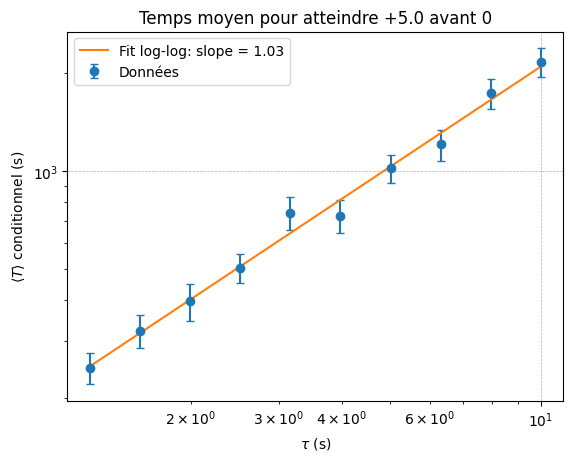

In [123]:
# Vos données
tau_values = np.array(tau_values)
mean_times = np.array(mean_times)
errors = np.array(errors)

# Mise en log
log_tau = np.log(tau_values)
log_t   = np.log(mean_times)

# Régression linéaire : log⟨T⟩ = m·logτ + b
m, b = np.polyfit(log_tau, log_t, 1)

# Construire la droite de régression en échelle linéaire
#   ⟨T⟩_fit = exp(b) * τ^m
tau_fit = np.linspace(tau_values.min(), tau_values.max(), 100)
t_fit   = np.exp(b) * tau_fit**m

# Tracé
plt.errorbar(tau_values, mean_times,
             yerr=1.96*errors,
             fmt='o', capsize=3,
             label='Données')
plt.plot(tau_fit, t_fit,
         '-', linewidth=1.5,
         label=f'Fit log-log: slope = {m:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\langle T\rangle$ conditionnel (s)')
plt.title(f"Temps moyen pour atteindre +{L} avant 0")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Simulation en 2D

In [87]:
def simulate_telegraph_box_2d(
    tau: float,
    t_max: float,
    v0: float = 1.0,
    box_dims: tuple[float, float] = (1.0, 1.0),
    x0: tuple[float, float] | None = None,
    rng=None
):
    """
    Simule un processus de télégraphe en 2D dans [0,Lx]×[0,Ly] avec rebonds spéculaires.
    Part de x0 (par défaut (Lx/2,0)).

    Renvoie
    -------
    times     : np.ndarray d'instants d'événements
    positions : np.ndarray de forme (N,2) des positions (x,y)
    """
    if rng is None:
        rng = np.random.default_rng()
    Lx, Ly = box_dims
    pos = np.array([Lx/2, 0.0]) if x0 is None else np.array(x0, dtype=float)
    # Direction initiale uniforme sur le cercle
    theta = rng.uniform(0, 2*np.pi)
    dir_vec = np.array([np.cos(theta), np.sin(theta)])

    t = 0.0
    times = [t]
    positions = [pos.copy()]
    dt_scat = rng.exponential(scale=tau)

    while t < t_max:
        # calcul des temps jusqu'aux murs pour chaque composante
        ts = []
        for coord, L, d in zip(pos, box_dims, dir_vec):
            if d > 0:
                ts.append((L - coord) / (v0 * d))
            elif d < 0:
                ts.append(coord / (v0 * -d))
            else:
                ts.append(np.inf)
        t_wall = min(ts)

        # choisir diffusion ou collision
        if dt_scat <= t_wall and t + dt_scat <= t_max:
            dt = dt_scat
            t += dt
            pos += v0 * dir_vec * dt
            # nouvelle diffusion programmée
            dt_scat = rng.exponential(scale=tau)
            # nouvelle direction aléatoire
            theta = rng.uniform(0, 2*np.pi)
            dir_vec = np.array([np.cos(theta), np.sin(theta)])
        else:
            dt = t_wall if t + t_wall <= t_max else (t_max - t)
            t += dt
            pos += v0 * dir_vec * dt
            # rebond spéculaire sur l'axe concerné
            axis = int(np.argmin(ts))
            dir_vec[axis] *= -1
            dt_scat -= dt

        times.append(t)
        positions.append(pos.copy())
        if t >= t_max:
            break

    return np.array(times), np.vstack(positions)

In [88]:
def mean_time_to_yopposite_2d(
    box_dims: tuple[float, float],
    tau: float,
    v0: float = 1.0,
    n_sims: int = 2000,
    t_max: float = 1e3,
    rng=None
):
    """
    Simule n_sims trajectoires 2D et renvoie <T> et son erreur-type
    pour atteindre y>=Ly (côté opposé) en partant de (Lx/2,0).
    """
    if rng is None:
        rng = np.random.default_rng()
    Ly = box_dims[1]
    hit_times = []

    for _ in range(n_sims):
        times, positions = simulate_telegraph_box_2d(
            tau, t_max, v0, box_dims, x0=(box_dims[0]/2, 0.0), rng=rng
        )
        ys = positions[:, 1]
        idx = np.argmax(ys >= Ly)
        if ys[idx] >= Ly:
            hit_times.append(times[idx])

    if not hit_times:
        return np.nan, np.nan
    arr = np.array(hit_times)
    return arr.mean(), arr.std(ddof=1) / np.sqrt(arr.size)

In [119]:
# Paramètres et exécution
box = (1.5, 5.0)        # (Lx, Ly)
v0 = 1.0                # vitesse
tau_values = np.logspace(0.1, 1.0, 10)
n_sims = 2000
mfp = 0.15
rng = np.random.default_rng(2025)

means = []
errors = []
for tau in tau_values:
    v0 = mfp / tau
    m, se = mean_time_to_yopposite_2d(box, tau, v0, n_sims, t_max=2e3, rng=rng)
    means.append(m)
    errors.append(se)
means = np.array(means)
errors = np.array(errors)

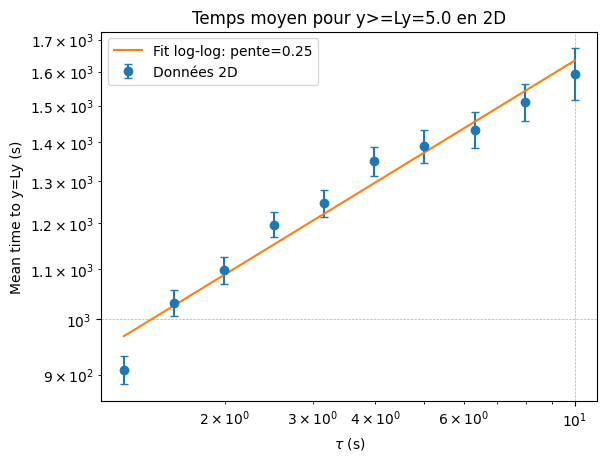

In [120]:
log_tau = np.log(tau_values)
log_m = np.log(means)
m_fit, b_fit = np.polyfit(log_tau, log_m, 1)
tau_fit = np.linspace(tau_values.min(), tau_values.max(), 100)
mean_fit = np.exp(b_fit) * tau_fit**m_fit

plt.errorbar(tau_values, means, yerr=1.96 * errors,
             fmt='o', capsize=3, label='Données 2D')
plt.plot(tau_fit, mean_fit, '-',
         label=f'Fit log-log: pente={m_fit:.2f}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\tau$ (s)'); plt.ylabel('Mean time to y=Ly (s)')
plt.title(f'Temps moyen pour y>=Ly={box[1]} en 2D')
plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.show()

# Simulation en 3D

In [126]:
def simulate_telegraph_box3D(tau: float,
                           t_max: float,
                           v0: float = 1.0,
                           box_dims: tuple[float, float, float] = (1.0, 1.0, 1.0),
                           x0: tuple[float, float, float] | None = None,
                           rng=None):
    """
    Simule un télégraphe en 3D dans [0,Lx]×[0,Ly]×[0,Lz] avec rebonds spéculaires.
    x0 permet de choisir la position initiale.
    """
    if rng is None:
        rng = np.random.default_rng()
    Lx, Ly, Lz = box_dims
    pos = np.array([0.0, 0.0, 0.0]) if x0 is None else np.array(x0, dtype=float)
    dir_vec = rng.normal(size=3)
    dir_vec /= np.linalg.norm(dir_vec)

    t = 0.0
    times = [t]
    positions = [pos.copy()]
    dt_scat = rng.exponential(scale=tau)

    while t < t_max:
        # temps jusqu'au prochain mur suivant chaque composante
        ts = []
        for coord, L, d in zip(pos, box_dims, dir_vec):
            if d > 0:
                ts.append((L - coord) / (v0 * d))
            elif d < 0:
                ts.append(coord / (v0 * -d))
            else:
                ts.append(np.inf)
        t_wall = min(ts)

        # choisir diffusion ou collision
        if dt_scat <= t_wall and t + dt_scat <= t_max:
            dt = dt_scat
            t += dt
            pos += v0 * dir_vec * dt
            # remise à zéro de dt_scat
            dt_scat = rng.exponential(scale=tau)
            # nouvelle direction aléatoire
            dir_vec = rng.normal(size=3)
            dir_vec /= np.linalg.norm(dir_vec)
        else:
            dt = t_wall if t + t_wall <= t_max else (t_max - t)
            t += dt
            pos += v0 * dir_vec * dt
            # rebond spéculaire sur l'axe minimal
            axis = int(np.argmin(ts))
            dir_vec[axis] *= -1
            dt_scat -= dt

        times.append(t)
        positions.append(pos.copy())
        if t >= t_max:
            break

    return np.array(times), np.vstack(positions)

In [127]:
def mean_time_to_yopposite3D(box_dims: tuple[float, float, float],
                           tau: float,
                           v0: float = 1.0,
                           n_sims: int = 2000,
                           t_max: float = 1e3,
                           rng=None):
    """
    Simule n_sims trajectoires et renvoie <T> et son erreur-type
    pour atteindre y>=Ly (paroi opposée) en partant de (0,0,0).
    """
    if rng is None:
        rng = np.random.default_rng()
    Ly = box_dims[1]
    hit_times = []

    for _ in range(n_sims):
        times, positions = simulate_telegraph_box3D(tau, t_max, v0, box_dims, x0=(box_dims[0]/2,box_dims[1]/2,box_dims[2]/2), rng=rng)
        # détecter premier franchissement y>=Ly
        ys = positions[:,1]
        idx = np.argmax(ys >= Ly)
        if ys[idx] >= Ly:
            hit_times.append(times[idx])

    if not hit_times:
        return np.nan, np.nan
    arr = np.array(hit_times)
    return arr.mean(), arr.std(ddof=1) / np.sqrt(arr.size)

In [131]:
# Paramètres et simulation
box = (1.5, 5.0, 2.0)    # dimensions (Lx, Ly, Lz)
v0 = 1.0                # vitesse
mfp = 0.15
tau_values = np.logspace(0.1, 1, 10)
n_sims = 3000
rng = np.random.default_rng(20253)

means = []
errors = []
for tau in tau_values:
    v0 = mfp / tau
    m, se = mean_time_to_yopposite3D(box, tau, v0, n_sims, t_max=1e3, rng=rng)
    means.append(m)
    errors.append(se)
means = np.array(means)
errors = np.array(errors)

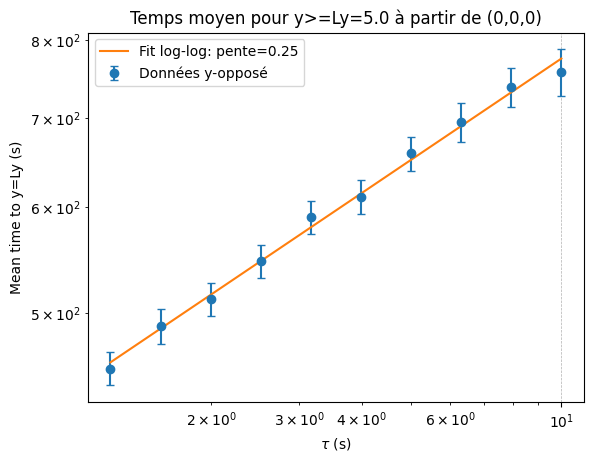

In [132]:
# Tracé log-log et régression linéaire
log_tau = np.log(tau_values)
log_m = np.log(means)
m_fit, b_fit = np.polyfit(log_tau, log_m, 1)
tau_fit = np.linspace(tau_values.min(), tau_values.max(), 100)
mean_fit = np.exp(b_fit) * tau_fit**m_fit

plt.errorbar(tau_values, means, yerr=1.96*errors,
             fmt='o', capsize=3, label='Données y-opposé')
plt.plot(tau_fit, mean_fit, '-',
         label=f'Fit log-log: pente={m_fit:.2f}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\tau$ (s)'); plt.ylabel('Mean time to y=Ly (s)')
plt.title(f'Temps moyen pour y>=Ly={box[1]} à partir de (0,0,0)')
plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.show()
